In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv('Datasets/galaxyquasar.csv')
df

,u,g,r,i,z,class,z1,zerr
0,18.97213,18.53676,18.58280,18.34936,18.29215,QSO,0.522819,0.000155
1,19.24592,17.47646,16.47817,16.04472,15.68851,GALAXY,0.122846,0.000028
2,19.43536,17.70268,16.91565,16.58327,16.39128,GALAXY,0.000000,0.000000
3,19.31626,18.18312,17.39591,16.94549,16.65395,GALAXY,0.147435,0.000009
4,19.28828,19.11188,18.88937,18.80013,18.49183,QSO,2.011455,0.000631
...,...,...,...,...,...,...,...,...
49995,19.37295,18.12382,17.39886,16.98503,16.70585,GALAXY,0.113016,0.000011
49996,18.52021,16.88262,16.03280,15.56884,15.22454,GALAXY,0.085063,0.000014
49997,18.62718,17.30876,16.87371,16.62399,16.42296,GALAXY,0.054429,0.000008
49998,19.55140,18.27711,17.62101,17.21947,17.03347,GALAXY,0.112571,0.000009


In [2]:
# evaluating all the differences and saving them in a dictionary
d={}
labels=['ug', 'gr', 'ri', 'iz', 'zu']
d[labels[0]] = df['u'].to_numpy() - df['g'].to_numpy()
d[labels[1]] = df['g'].to_numpy() - df['r'].to_numpy()
d[labels[2]] = df['r'].to_numpy() - df['i'].to_numpy()
d[labels[3]] = df['i'].to_numpy() - df['z'].to_numpy()
d[labels[4]] = df['z'].to_numpy() - df['u'].to_numpy()
d['cl'] = df['class'].map({'GALAXY': 0, 'QSO': 1}).to_numpy()
print(d)

{'ug': array([0.43537, 1.76946, 1.73268, ..., 1.31842, 1.27429, 1.05021]), 'gr': array([-0.04604,  0.99829,  0.78703, ...,  0.43505,  0.6561 ,  0.35251]), 'ri': array([0.23344, 0.43345, 0.33238, ..., 0.24972, 0.40154, 0.1885 ]), 'iz': array([0.05721, 0.35621, 0.19199, ..., 0.20103, 0.186  , 0.09355]), 'zu': array([-0.67998, -3.55741, -3.04408, ..., -2.20422, -2.51793, -1.68477]), 'cl': array([1, 0, 0, ..., 0, 0, 0])}


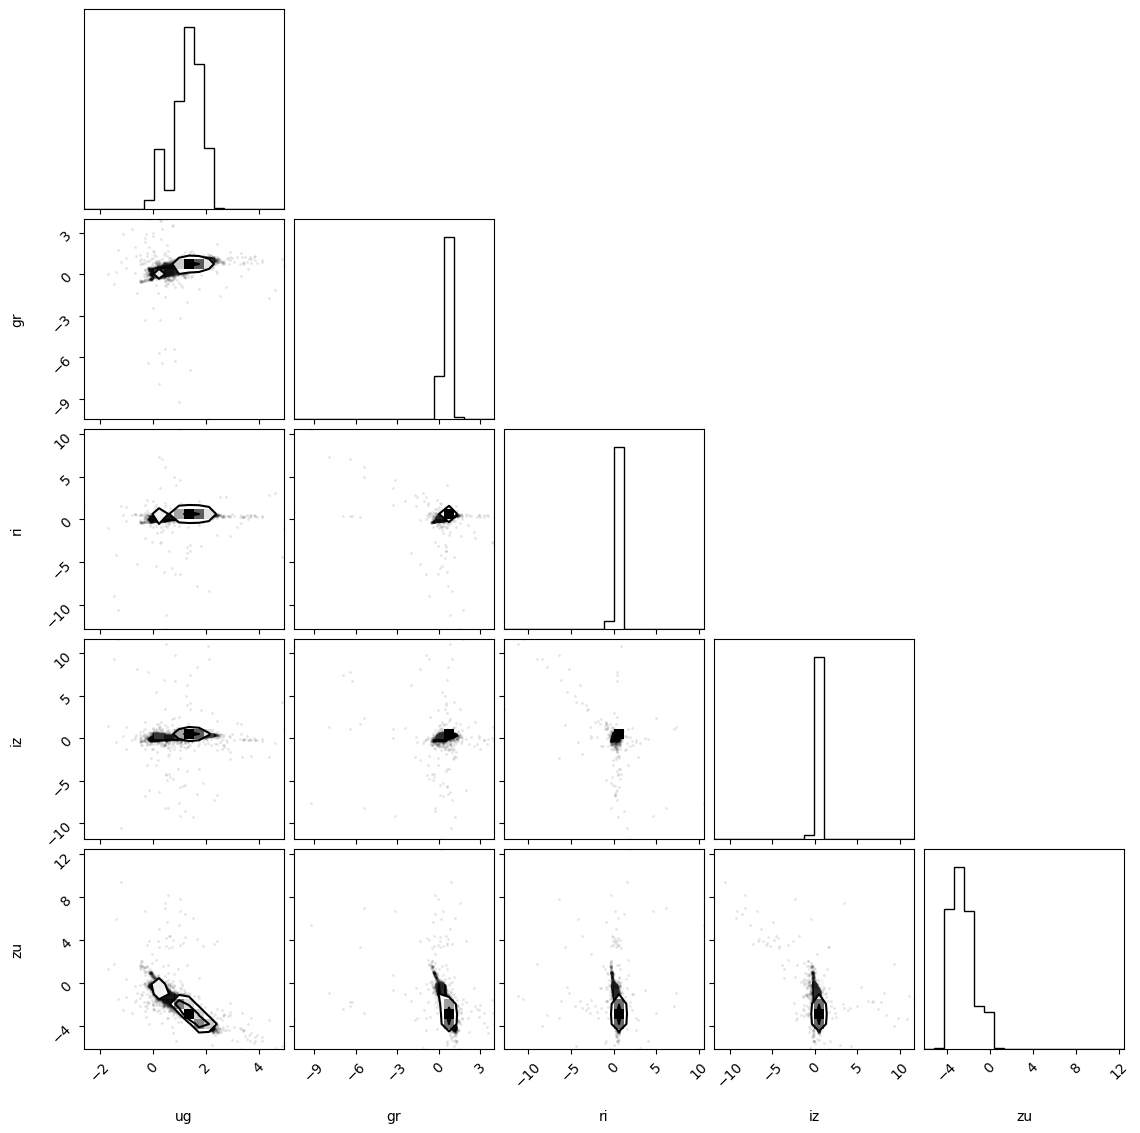

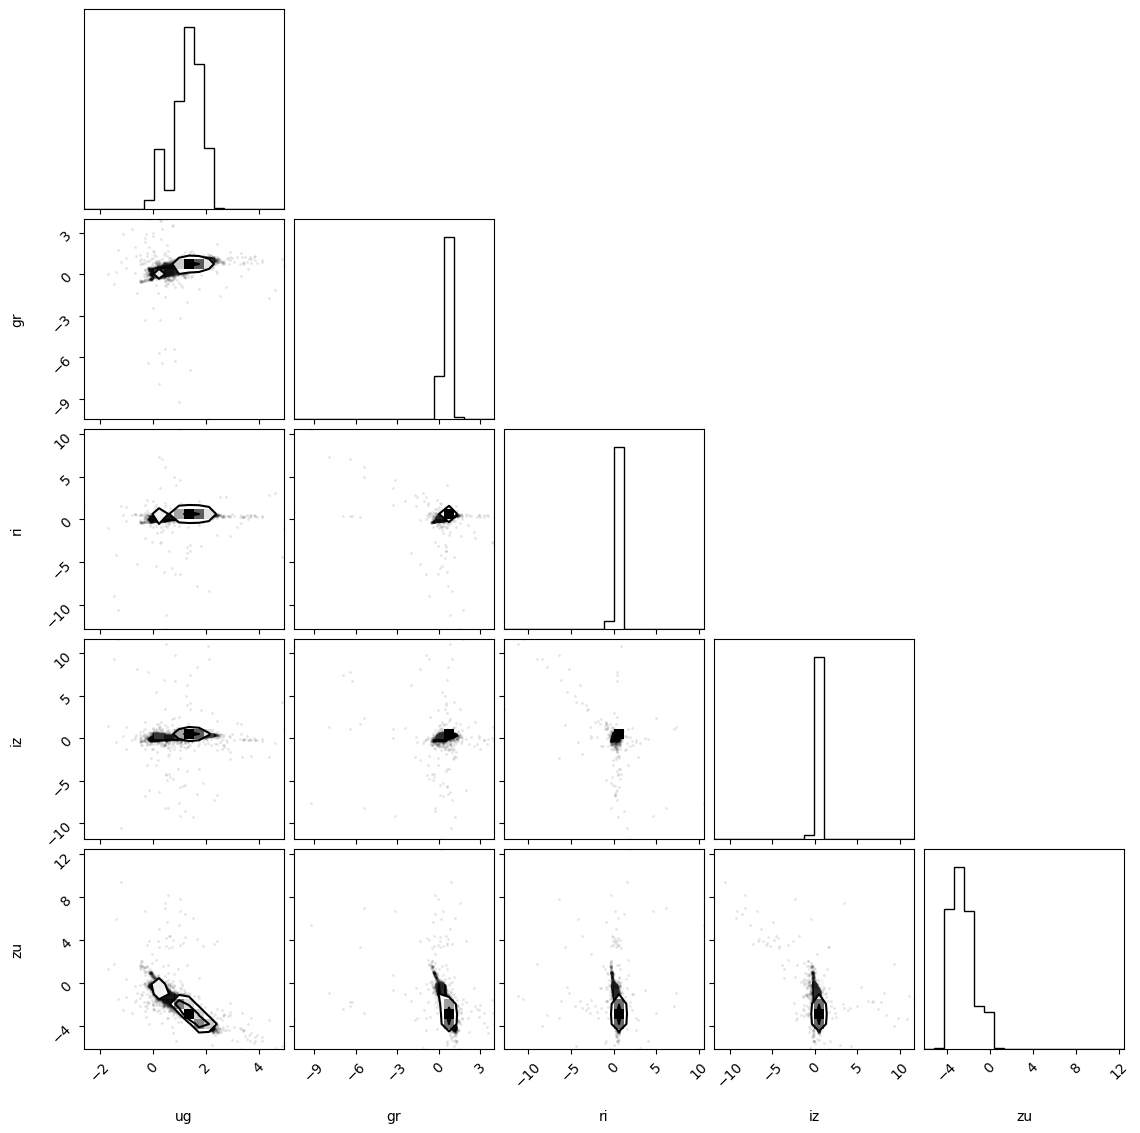

In [3]:
# plotting a corner plot to visualize the histogram
# in order to find possible bimodal behaviours
import corner
corner.corner(np.array([d['ug'],d['gr'],d['ri'],d['iz'],d['zu']]).T,levels=[0.68,0.95], labels=labels)

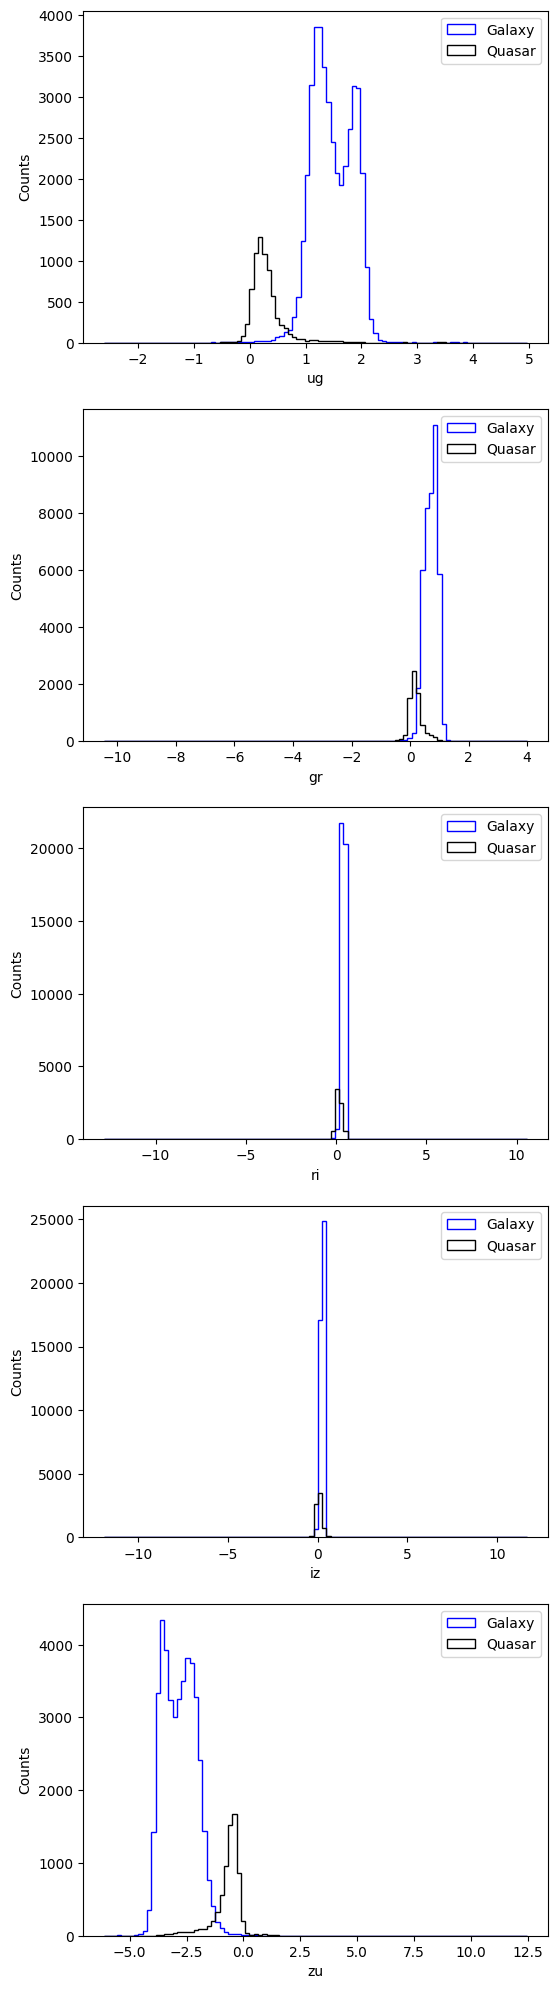

In [4]:
# ug and zu looks like could presento two distinguished subset of populations,
# so let's plot all the distribution with their actual label
fig,ax = plt.subplots(5,1,figsize=(6,25))
name = ['Galaxy','Quasar']
c=['blue','black']
for j in range(0,5):
    for i in [0,1]:
        ax[j].hist(d[labels[j]][d['cl']==i],color=c[i],label=name[i],histtype='step',
        bins=np.linspace(min(d[labels[j]]),max(d[labels[j]]),100))
    ax[j].set(xlabel=labels[j],ylabel='Counts')
    ax[j].legend()


In [5]:
# as expected, it looks like what we speculated
# let's confirm that by using some different models to see which parameter of our dataset is the most informative
# for this task is useful to define a function that automatically print the roc curve and completeness over contamination
# and that automatically implements throught a pipeline a standardscaler to rescale the datas

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.base import clone

X = np.array([d['ug'], d['gr'], d['ri'], d['iz'], d['zu']]).T
y = d['cl']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

def print_roc_sing(model, ax1, ax2):
    for i in range(5):
        pipe = make_pipeline(StandardScaler(),
                             clone(model))
        
        pipe.fit(X_train[:, [i]], y_train)
        y_prob = pipe.predict_proba(X_test[:, [i]])[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        precision, recall, _ = precision_recall_curve(y_test, y_prob)
        ax1.plot(fpr, tpr, label=labels[i])
        ax2.plot(precision, recall, label=labels[i])

    ax1.set(xlabel='False Positive Rate',ylabel='True Positive Rate')
            # xlim=(0,0.1),ylim=(0.9,0.98))
            # xscale='log',yscale='log')
    ax1.legend(title=str(model),alignment='left')
    ax2.set(xlabel='Efficiency',ylabel='Completeness',
            xlim=(0,1),ylim=(0.2,1.02))
            # xscale='log', yscale='log')
    ax2.legend(title=str(model),alignment='left')


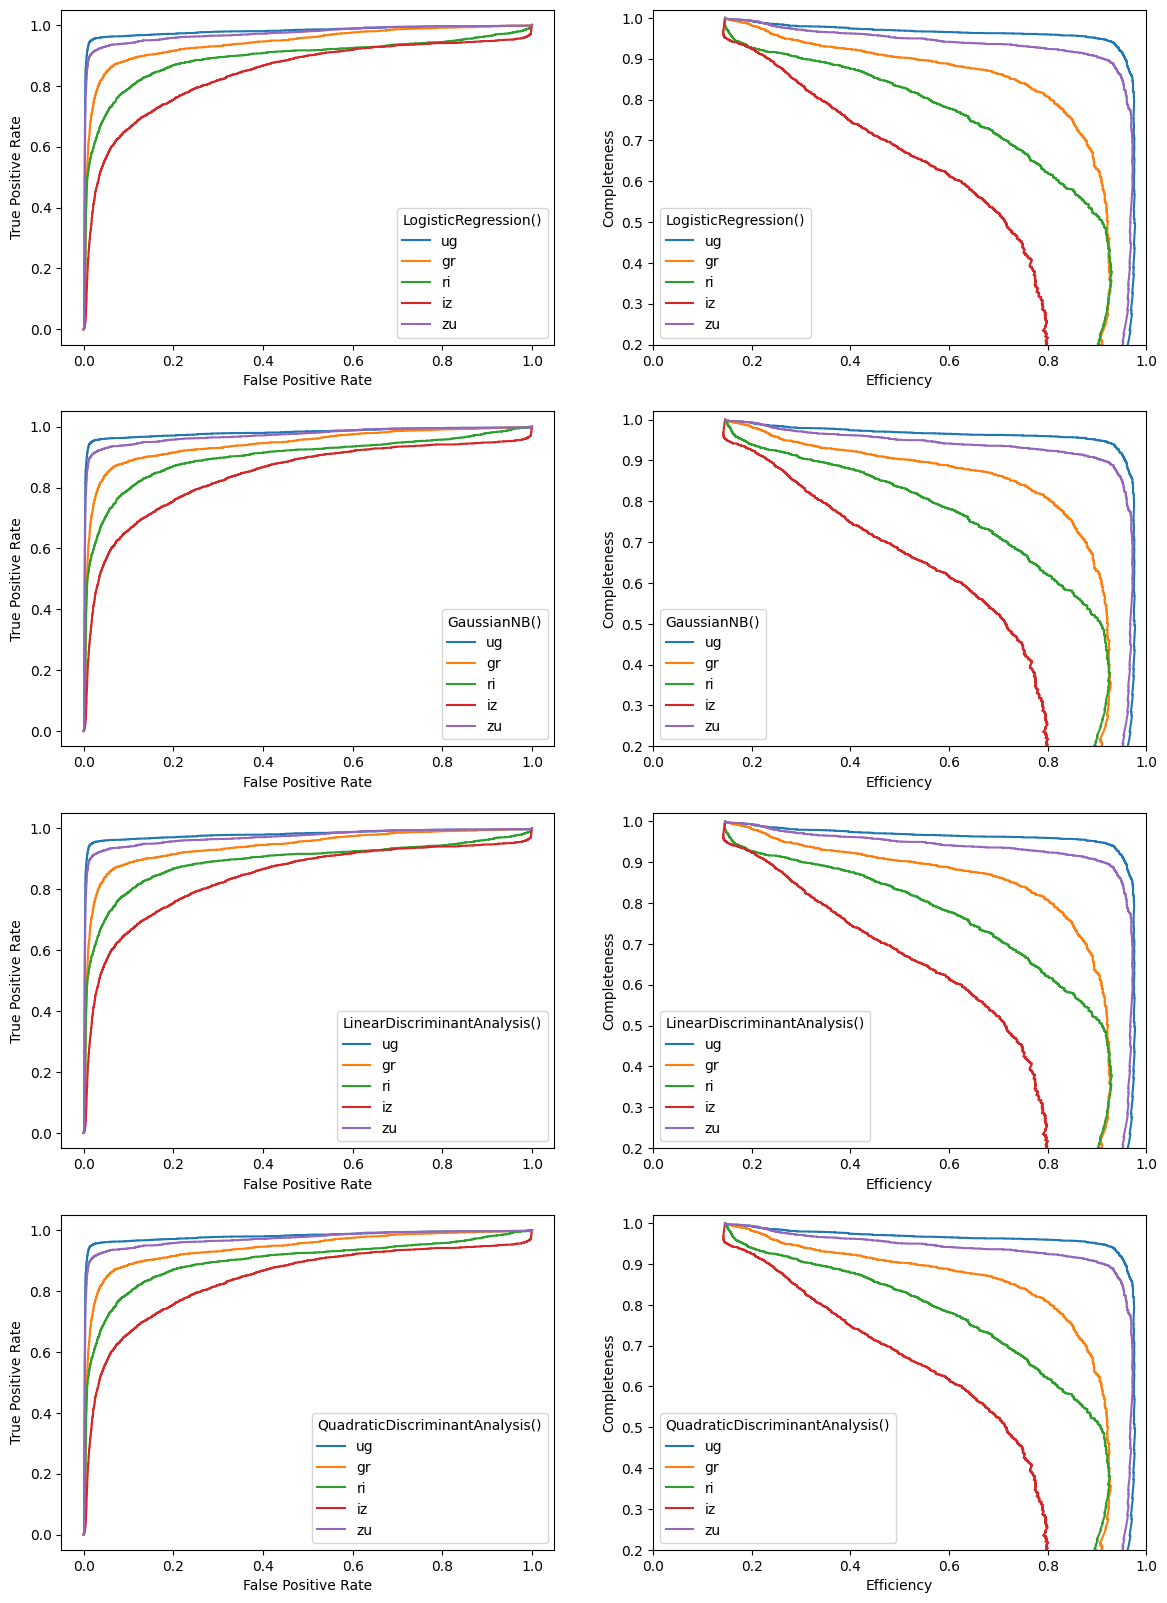

In [6]:
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA, QuadraticDiscriminantAnalysis as QDA
from sklearn.neighbors import KNeighborsClassifier
from astroML.classification import GMMBayes

models = [LogisticRegression(),GaussianNB(),LDA(),QDA()]
fig,ax = plt.subplots(len(models),2,figsize=(14,5*len(models)))

for j in range(len(models)):
    print_roc_sing(models[j],ax[j][0],ax[j][1])


In [7]:
# as expected, all the methods shows that ug and zu are the most informative subsets of data in our possession
# now let's define a function to fit the whole dataset, similarly as what we've done before

def print_roc(model):
    pipe = make_pipeline(StandardScaler(),
                             clone(model))
    pipe.fit(X_train, y_train)
    y_prob = pipe.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    y_pred = pipe.predict(X_test)
    
    C = confusion_matrix(y_test, y_pred)

    return fpr, tpr, C

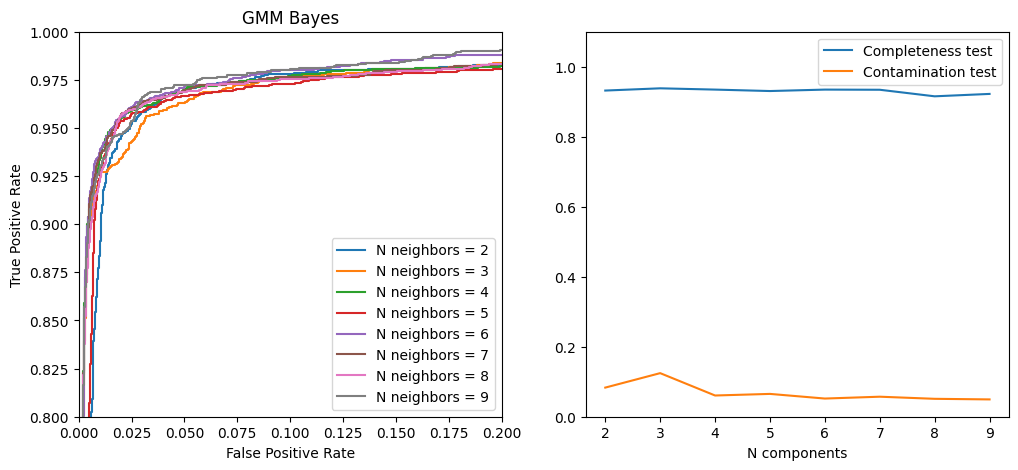

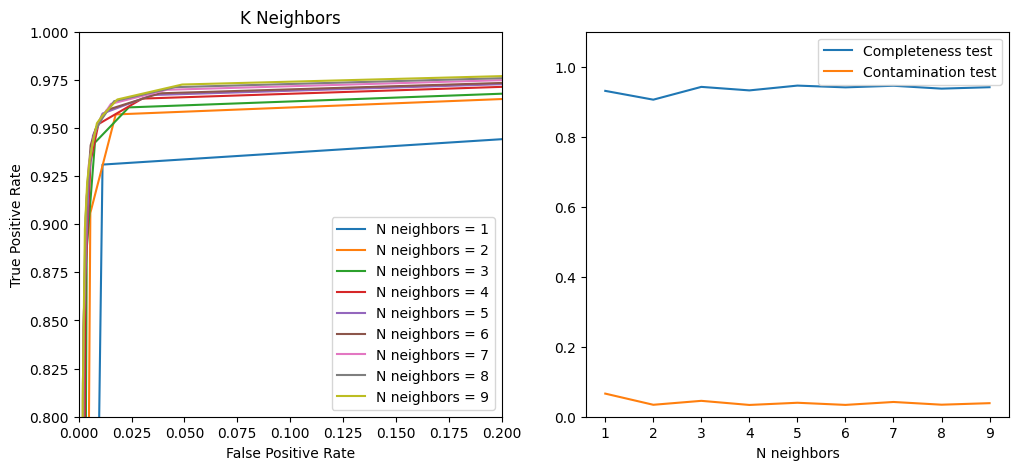

In [9]:
# let's look briefly at how GMM bayes and K neighbors performs respectively
# at different n_components and n_neighbors values
# this is just to find some values that looks good enough to later compare those two models with others
# later for a more accurate choice of the parameters

# GMM Bayes
fig,ax = plt.subplots(1,2,figsize=(12,5))
completeness=[]
contamination=[]
for i in np.arange(2,10):
    model = GMMBayes(n_components=i)
    fpr, tpr, C = print_roc(model)
    tn, fp, fn, tp = C.ravel()
    completeness.append(tp/(tp+fn))
    contamination.append(fp/(tp+fp))
    ax[0].plot(fpr, tpr, label=f'N neighbors = {i:d}')
ax[0].set(xlabel='False Positive Rate',ylabel='True Positive Rate',title='GMM Bayes',
          xlim=(0,0.2),ylim=(0.8,1))
ax[0].legend()
ax[1].plot(np.arange(2,10),completeness,label='Completeness test')
ax[1].plot(np.arange(2,10),contamination,label='Contamination test')
ax[1].set(xlabel='N components',ylim=(0,1.1))
ax[1].legend()

# K Neighbors
fig,ax = plt.subplots(1,2,figsize=(12,5))
completeness=[]
contamination=[]
for i in np.arange(1,10):
    model = KNeighborsClassifier(n_neighbors=i)
    fpr, tpr, C = print_roc(model)
    tn, fp, fn, tp = C.ravel()
    completeness.append(tp/(tp+fn))
    contamination.append(fp/(tp+fp))
    ax[0].plot(fpr, tpr, label=f'N neighbors = {i:d}')
ax[0].set(xlabel='False Positive Rate',ylabel='True Positive Rate',title='K Neighbors',
          xlim=(0,0.2),ylim=(0.8,1))
ax[0].legend()
ax[1].plot(np.arange(1,10),completeness,label='Completeness test')
ax[1].plot(np.arange(1,10),contamination,label='Contamination test')
ax[1].set(xlabel='N neighbors',ylim=(0,1.1))
ax[1].legend()

LogisticRegression()
Completeness: 0.915      Contamination: 0.051
GaussianNB()
Completeness: 0.931      Contamination: 0.140
LinearDiscriminantAnalysis()
Completeness: 0.926      Contamination: 0.057
QuadraticDiscriminantAnalysis()
Completeness: 0.829      Contamination: 0.045


/home/giacomo/myenv/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/giacomo/myenv/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(


GMMBayes(n_components=array([6]))
Completeness: 0.924      Contamination: 0.052
KNeighborsClassifier(n_neighbors=9)
Completeness: 0.941      Contamination: 0.039


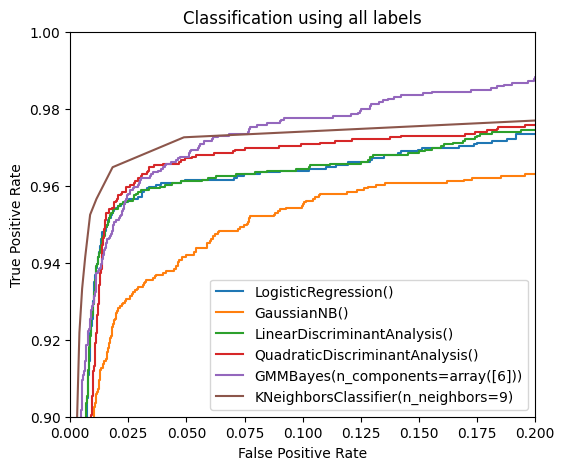

In [10]:
# let's now compare different classification procedures
# the one that will perform the best in terms of completeness and contamination
# will then be cross validated to optimize the parameters choice

fig,ax = plt.subplots(1,1,figsize=(6,5))
models = [LogisticRegression(),GaussianNB(),LDA(),QDA(),GMMBayes(n_components=6),KNeighborsClassifier(n_neighbors=9)]
for j in models:
    fpr, tpr, C = print_roc(j)
    print(str(j))
    tn, fp, fn, tp = C.ravel()
    print(f'Completeness: {tp/(tp+fn):.3f}      Contamination: {fp/(tp+fp):.3f}')
    ax.plot(fpr, tpr, label=str(j))

ax.set(xlabel='False Positive Rate',ylabel='True Positive Rate',title='Classification using all labels',
xlim=(0,0.2),ylim=(0.9,1))
ax.legend()

Best parameters: {'kneighborsclassifier__metric': 'euclidean', 'kneighborsclassifier__n_neighbors': 7, 'kneighborsclassifier__weights': 'distance'}
Best score: 0.9856857142857143
Accuracy on test set: 0.9858
Completeness: 0.944      Contamination: 0.042


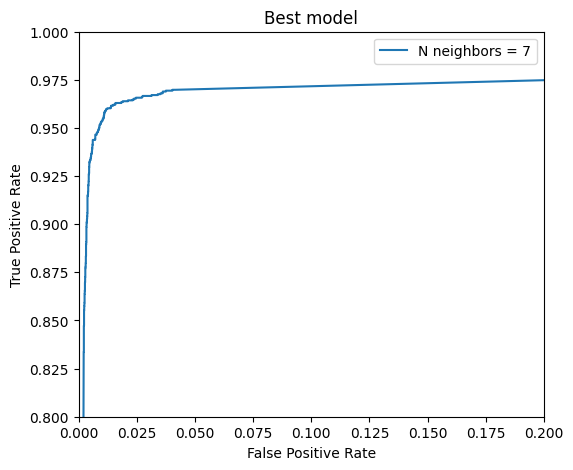

In [12]:
# kneighbors seems to behave the best between those models, so let's now cross validate

from sklearn.model_selection import GridSearchCV

pipe = make_pipeline(
    StandardScaler(),
    KNeighborsClassifier()
)
n_neighbors=np.arange(1,10)
param_grid = {
    'kneighborsclassifier__n_neighbors': np.arange(1,10),
    'kneighborsclassifier__weights': ['uniform', 'distance'],
    'kneighborsclassifier__metric': ['euclidean', 'manhattan']
}

grid = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

grid.fit(X_train, y_train)

print("Best parameters:", grid.best_params_)
print("Best score:", grid.best_score_)
print("Accuracy on test set:", grid.score(X_test, y_test))

y_prob = grid.predict_proba(X_test)[:,1]
y_pred = grid.predict(X_test)

C = confusion_matrix(y_test, y_pred)
fpr, tpr, thresh = roc_curve(y_test, y_prob)
fig,ax = plt.subplots(1,1,figsize=(6,5))
ax.plot(fpr, tpr, label=f'N neighbors = {grid.best_params_['kneighborsclassifier__n_neighbors']:d}')
ax.set(xlabel='False Positive Rate',ylabel='True Positive Rate',title='Best model',
          xlim=(0,0.2),ylim=(0.8,1))
ax.legend()
tn, fp, fn, tp = C.ravel()
print(f'Completeness: {tp/(tp+fn):.3f}      Contamination: {fp/(tp+fp):.3f}')